# 4.A. Generalized Entropy

* In the study of dynamical systems there are many quantities that identify as "entropy".
* These quantities are not the more commonly known [thermodynamic ones](https://en.wikipedia.org/wiki/Entropy), used in Statistical Physics. 
* Rather, they are more like the entropies of [information theory](https://en.wikipedia.org/wiki/Entropy_(information_theory), which represent information contained within a dataset. 
* In general, the more "uncertain" or "random" the dataset is, the larger its entropy will be. On the other hand, the lower the entropy, the more "predictable" the dataset becomes.


Let $p$ be an array of probabilities (such that it sums to 1). Then the generalized entropy is defined as 

$$
H_\alpha(p) = \frac{1}{1-\alpha}\log\left(\sum_i p[i]^\alpha\right)
$$

and is also called [Rényi entropy](https://en.wikipedia.org/wiki/R%C3%A9nyi_entropy). Other entropies, like e.g. the [Shannon entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory) are generalized by it, since for $\alpha = 1$, the Rényi entropy becomes the Shannon entropy,

$$
H_1(p) = -\left(\sum_i p[i] \log (p[i]) \right)
$$

The Rényi entropy can be computed for a specific dataset, given $p$. But how does one get $p$?
1. $p$ represents the probability that a point of a dataset falls into a specific "bin". 
2. It is nothing more than the (normalized) histogram of the dataset!

In [1]:
using DynamicalSystems
using PyPlot
PyPlot.rc("font", size = 16)          # set default fontsize
PyPlot.rc("figure", figsize = (6, 4)) # set default figsize

┌ Info: Recompiling stale cache file C:\Users\datseris\.julia\compiled\v1.1\DynamicalSystems\TY1vN.ji for DynamicalSystems [61744808-ddfa-5f27-97ff-6e42cc95d634]
└ @ Base loading.jl:1184


Let's generate a dataset so that we can start calculating entropies.

In [2]:
N = 100000
randomdata = Dataset(rand(N,3))

3-dimensional Dataset{Float64} with 100000 points
 0.971254   0.692154   0.0693175
 0.368289   0.744372   0.204021 
 0.50411    0.930293   0.101432 
 0.60112    0.823466   0.284311 
 0.99343    0.922404   0.555815 
 0.908516   0.650509   0.494317 
 0.02996    0.0413851  0.0337484
 0.165807   0.901557   0.779436 
 0.544042   0.864026   0.927016 
 0.498625   0.51513    0.698508 
 0.605703   0.219119   0.722354 
 0.977495   0.657041   0.209247 
 0.0514617  0.395721   0.529909 
 ⋮                              
 0.698052   0.425412   0.817118 
 0.103539   0.982603   0.53481  
 0.944496   0.210988   0.166094 
 0.0342689  0.57217    0.657196 
 0.825213   0.615185   0.770846 
 0.278481   0.778215   0.362606 
 0.139496   0.0195272  0.991478 
 0.035514   0.244147   0.137734 
 0.983501   0.948756   0.377954 
 0.527239   0.399416   0.0878329
 0.772413   0.991027   0.72123  
 0.0899255  0.965205   0.228922 


---
The call signature we need is

```julia
genentropy(α, ε, dataset::AbstractDataset; base = e)
```
* This function calculates the generalized entropy of order `α`.
* It first calculates the probability array $p$.
* The "histogram" is created by partitioning the `dataset` into boxes of size `ε`.


In [3]:
genentropy(2, 0.1, randomdata)

6.897784552297363

In [4]:
genentropy(2, 0.01, randomdata)

11.416325208580945

In [5]:
genentropy(2, 0.001, randomdata)

11.512885465769228

In [6]:
genentropy(2, 0.0001, randomdata)

11.512925464969248

Note that the output of `genentropy` changed with changing $\varepsilon$ until we hit $\varepsilon = 0.001$. 

At this point the value for the entropy has already saturated. There's no use in partitioning the dataset in smaller boxes. Every bin already contains at most one point.

---


`genentropy` is conveniently used with outputs of e.g. `trajectory` or `poincaresos`, because they return a `Dataset`.

Here we create a trajectory for the towel map, a three dimensional chaotic discrete system.

In [7]:
towel = Systems.towel()

3-dimensional discrete dynamical system
 state:       [0.085, -0.121, 0.075]
 e.o.m.:      eom_towel
 in-place?    false
 jacobian:    jacob_towel
 parameters:  nothing

In [8]:
tr = trajectory(towel, N-1);
summary(tr)

"3-dimensional Dataset{Float64} with 100000 points"

and calculate its entropy:

In [9]:
genentropy(1, 0.01, tr)

9.471952690471404

Let's also compare the entropy of the above dataset (a trajectory of the towel map) with that of a random dataset:

In [10]:
genentropy(1, 0.01, randomdata)

11.444104663471505

* As expected, the entropy of the random dataset is higher.

---

How much time does the computation take?

In [11]:
using BenchmarkTools
@btime genentropy(1, 0.01, $tr);

  19.587 ms (7 allocations: 3.05 MiB)


# 4.B. Specialized histogram
* Partitioning the dataset (i.e. generating a "histogram") is in general a costly operation that depends exponentially on the number of dimensions.
* In this specific application however, we can tremendously reduce the memory allocation and time spent!

To get the array of probabilities `p` for size `ε` from the trajectory of the towel map we use the function `non0hist`

In [12]:
ε = 0.01
p = non0hist(ε, tr)

19407-element Array{Float64,1}:
 1.0e-5 
 1.0e-5 
 3.0e-5 
 0.00033
 0.00022
 0.0002 
 0.00017
 0.00013
 7.0e-5 
 0.00011
 7.0e-5 
 0.00015
 0.00019
 ⋮      
 2.0e-5 
 1.0e-5 
 3.0e-5 
 4.0e-5 
 5.0e-5 
 4.0e-5 
 2.0e-5 
 3.0e-5 
 4.0e-5 
 5.0e-5 
 1.0e-5 
 1.0e-5 

Here's a sanity check, showing our probabilities should sum to `1`.

In [13]:
sum(p)

1.0000000000000002

How long does computing the probabilities take?

In [14]:
@btime non0hist($ε, $tr);

  19.947 ms (6 allocations: 3.05 MiB)


How long does this take if we create 9-dimensional data and compare again?

In [15]:
nine = Dataset(rand(N, 9))
@btime non0hist($ε, $nine);

  25.466 ms (6 allocations: 7.63 MiB)


`non0hist` uses a very specialized (to-be-published) algorithm and its time does not depend exponentially on the dimensionality of the dataset, instead only linearly. It also has a linearithmic complexity (`n log(n)`) on the number of points.

# 4.C. Generalized Dimension
1. There are numerous methods that one can use to calculate a so-called "dimension" of a
dataset, like for example the [Fractal dimension](https://en.wikipedia.org/wiki/Fractal_dimension).

2. Most of the time these dimensions indicate some kind of scaling behavior. 

3. For example, the scaling of `genentropy` with decreasing `ε` gives the so-called "generalized dimension".


$ E \approx -D\log(\varepsilon)$ with $E$ the entropy and $D$ the "dimension".

---
Let's find out the dimension of the attractor of the Towel Map!



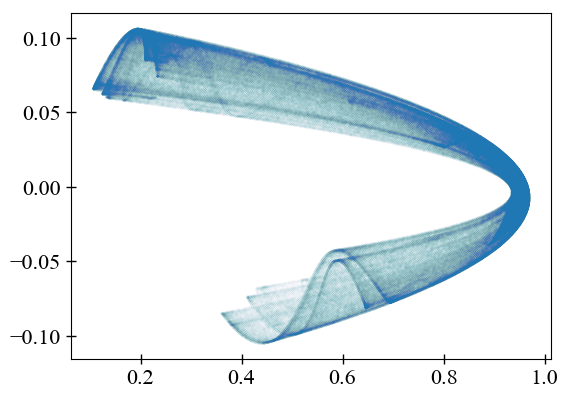

In [37]:
towel = Systems.towel()
towel_tr = trajectory(towel, 1000000, Ttr = 100);
plot(towel_tr[:, 1], towel_tr[:, 2], ls = "None", marker = "o", ms = 0.1, alpha = 0.1);

*(Note that more points = more precision = more computations = more time!)*

Now we have to compute `genentropy` for different ε.

Which ε should we use...?

Let's do a "random" guess...

In [17]:
ες =  10.0 .^ range(-4, stop=1, length=12)

12-element Array{Float64,1}:
  0.0001                
  0.00028480358684358016
  0.0008111308307896872 
  0.0023101297000831605 
  0.006579332246575682  
  0.01873817422860384   
  0.0533669923120631    
  0.15199110829529336   
  0.43287612810830584   
  1.2328467394420661    
  3.511191734215131     
 10.0                   

In [18]:
Es = zero(ες)
for (i, ε) ∈ enumerate(ες)
    Es[i] = genentropy(1, ε, towel_tr)
end
Es

12-element Array{Float64,1}:
 13.81169511444466  
 13.781251823885533 
 13.559365425765614 
 12.546973720631664 
 10.484145611870376 
  8.234104294388032 
  5.983454782350074 
  3.7462781419120246
  1.2935711847117133
 -0.0               
 -0.0               
 -0.0               

**Shorter version (thanks broadcasting!)**

In [19]:
Es = genentropy.(1, ες, Ref(towel_tr))

12-element Array{Float64,1}:
 13.81169511444466  
 13.781251823885533 
 13.559365425765614 
 12.546973720631664 
 10.484145611870376 
  8.234104294388032 
  5.983454782350074 
  3.7462781419120246
  1.2935711847117133
 -0.0               
 -0.0               
 -0.0               

*usage of `Ref` ensures broadcasting over `ες` but not over `towel_tr`, which is also iterable.*

Alright. Remember that it should be that $E \approx -D\log(\varepsilon)$
 with $E$ the entropy and $D$ the "dimension". 

Let's plot and see:

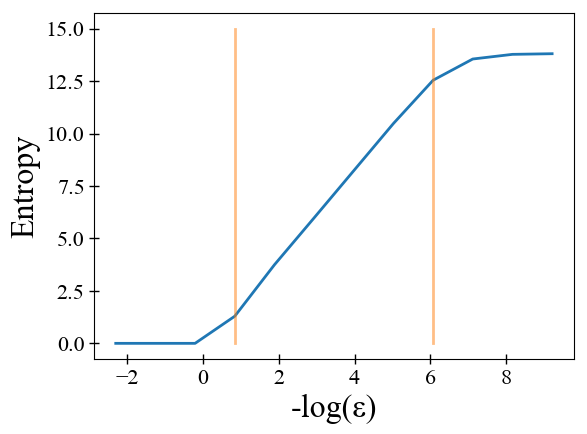

In [20]:
x = -log.(ες)
plot(x, Es); xlabel("-log(ε)"); ylabel("Entropy");
plot([x[4], x[4]], [0, 15], color = "C1", alpha = 0.5)
plot([x[end-3], x[end-3]], [0, 15], color = "C1", alpha = 0.5);

What typically happens is that there is some region where this scaling behavior holds, but then it stops holding due to the finite amount of data points.

Above, the expected scaling behavior holds between the orange vertical lines.

Let's choose the curve points that do fall in the linear regime of the above plot,

In [21]:
x, y = -log.(ες)[4:end-2], Es[4:end-2]

([6.07045, 5.02382, 3.97719, 2.93056, 1.88393, 0.837304, -0.209326], [12.547, 10.4841, 8.2341, 5.98345, 3.74628, 1.29357, -0.0])

and find the slope of the curve there, to calculate the dimension, D.

In [22]:
using ChaosTools
offset, slope = ChaosTools.linreg(x, y)
D = slope

2.0647875290900046

This is actually a correct result, the information dimension of the attractor of the towel map is around 2.

---

* Are the values of `ες` we used good? 
* For a general dataset, how can we determine them?

the function `estimate_boxsizes(dataset; kwargs...)` can help with that!

In [23]:
ες = estimate_boxsizes(towel_tr)

12-element Array{Float64,1}:
 0.0001               
 0.0001873817422860385
 0.0003511191734215131
 0.0006579332246575682
 0.0012328467394420659
 0.0023101297000831605
 0.004328761281083057 
 0.008111308307896872 
 0.01519911082952934  
 0.02848035868435802  
 0.0533669923120631   
 0.1                  

Let's plot $E$ vs. $-\log \epsilon$ again

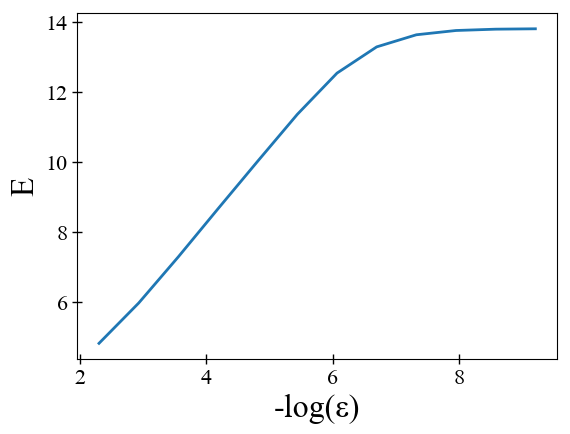

In [24]:
Es = genentropy.(1, ες, Ref(towel_tr))
plot(-log.(ες), Es); xlabel("-log(ε)"); ylabel("E");

---
# 4.D. Automated Dimension Estimation

Given some arbitrary plot like the one above, is there any algorithm to deduce a scaling region???

The function `linear_regions(x, y; kwargs...)` decomposes the function `y(x)` into regions where  the function is linear.

It returns the indices of `x` that correspond to linear regions and the approximated tangents at each region!

In [25]:
xs = -log.(ες)
lrs, slopes = linear_regions(xs, Es)

([1, 2, 3, 4, 5, 6, 12], [0.0171639, 0.0601715, 0.194438, 0.54999, 1.1922, 1.87338])

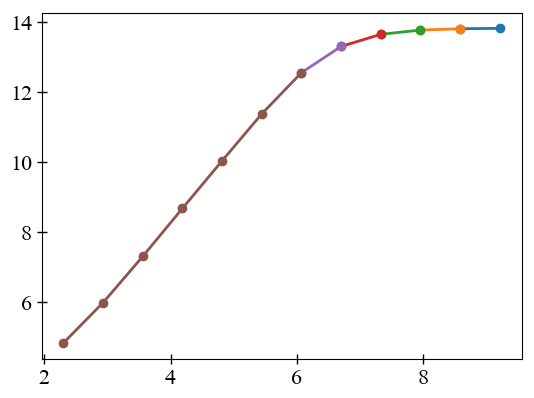

In [26]:
for i in 1:length(lrs)-1
    plot(xs[lrs[i]:lrs[i+1]], Es[lrs[i]:lrs[i+1]], marker = "o")
end

The linear region which is biggest is the "probably correct one". The function `linear_region` estimates its slope:

In [27]:
linear_region(xs, Es)[2]

2.0839648692762864

## `generalized_dim` function

Let's summarize what we just did to estimate the dimension of an attractor.

1. We decided on some partition sizes `ες` to use (the function `estimate_boxsizes` can give an estimate for that).
2. For each `ε` in `ες` we calculated the entropy via `genentropy`. We stored these entropies in an array `Es`.
3. We tried to find a "linear scaling region" of the curve `Es` vs. `-log.(ες)`.
4. The slope of this "linear scaling region" is the dimension we estimated.

Wouldn't it be **cool** if all of this process could happen with one function call?

This is *exactly* what the following function does:
```julia
generalized_dim(α, dataset, ες = estimate_boxsizes(tr))
```
which computes the `α`-order generalized dimension.

In [28]:
generalized_dim(2.0, tr)

┌ Warning: Boxsizes limits do not differ by 2 orders of magnitude or more. Setting `w -= 0.5; z += 0.5`. Please adjust keywords or provide a bigger dataset.
└ @ ChaosTools C:\Users\datseris\.julia\dev\ChaosTools\src\dimensions\dims.jl:157


2.0550760646700748

Similarly, let's calculate the dimension of the Henon map that we have seen in previous tutorials,

In [29]:
hen = Systems.henon()
tr = trajectory(hen, 200000)
generalized_dim(0, tr)

1.2192730981829056

### `generalized_dim` is but a crude estimate!

**You must check and double-check and triple-check if you want more accuracy!**

## Confirming Takens Theorem

Recalling back from notebook 3, we discussed delay embeddings and how Takens theorem states that quantities like e.g. the attractor dimension remain the same between reconstructed and original systems.

We can now show this numerically. We start with a trajectory from the system we used in notebook 3

In [30]:
g = Systems.gissinger(ones(3))

3-dimensional continuous dynamical system
 state:       [1.0, 1.0, 1.0]
 e.o.m.:      gissinger_eom
 in-place?    false
 jacobian:    ForwardDiff
 parameters:  [0.119, 0.1, 0.9]

In [31]:
dt = 0.05
data = trajectory(g, 20000.0, dt = dt, Ttr = 100.0)
summary(data)

"3-dimensional Dataset{Float64} with 400001 points"

We estimate a good delay time using the first minimum of the mutual information

In [32]:
τ = estimate_delay(data[:, 1], "mi_min")

53

And embed the timeseries in three dimensions

In [33]:
R = embed(data[:, 1], 3, τ)
summary(R)

"3-dimensional Dataset{Float64} with 399895 points"

Using `generalized_dim` we can now compare the dimension estimated for the original trajectory `data` and the reconstructed trajectory `R`

In [34]:
generalized_dim(1, data)

1.8894894898934165

In [35]:
generalized_dim(1, R)

2.0039164004150045